In [52]:
import importlib

import joblib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from Utils import paths
from Utils import transformation_utils as t_utils

importlib.reload(t_utils)

<module 'Utils.transformation_utils' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\transformation_utils.py'>

In [35]:
# Cargamos los datos originales
fhr = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/fhr_ctu-chb.pickle")
uc = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/uc_ctu-chb.pickle")
clinical = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/clinical_ctu-chb.pickle")

fhr.columns = fhr.columns.astype('float64')
uc.columns = uc.columns.astype('float64')

# Labels
y = clinical['ph'].apply(lambda x: 0 if x >= 7.2 else 1)

fhr.shape, uc.shape, clinical.shape

((552, 21620), (552, 21620), (552, 17))

In [36]:
fhr_clean = fhr.copy()
uc_clean = uc.copy()

threshold = 5 * 4
for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr_clean.iterrows(), uc_clean.iterrows()), total=len(uc_clean)):
    fhr_row[(fhr_row <= 0) | (fhr_row >= 250)] = np.nan
    uc_row[uc_row <= 0] = np.nan

    constant_parts_fhr = [x for x in np.split(fhr_row.index, np.where(np.diff(fhr_row.values) != 0)[0] + 1) if
                          x.size > threshold]
    constant_parts_uc = [x for x in np.split(uc_row.index, np.where(np.diff(uc_row.values) != 0)[0] + 1) if
                         x.size > threshold]

    for constant_part in constant_parts_fhr:
        fhr_row[constant_part] = np.nan

    for constant_part in constant_parts_uc:
        uc_row[constant_part] = np.nan

  0%|          | 0/552 [00:00<?, ?it/s]

In [47]:
nans = []
for min_num_points in [100, 1000, 2000, 3000, 5000, 7000, 10000]:
    cc_data = dict()
    lags = t_utils.calc_lags(minutes=5)

    for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr_clean.copy().iterrows(), uc_clean.copy().iterrows()),
                                                     total=len(uc_clean)):
        fhr_signal = pd.Series(fhr_row.values)
        uc_signal = pd.Series(uc_row.values)

        cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
            joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, min_num_points=min_num_points) for lag in lags
        )

    cc_df = pd.DataFrame(cc_data).T
    cc_df.columns = lags
    nans.append(cc_df.index[cc_df.isna().sum(axis=1) > 0])

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

  0%|          | 0/552 [00:00<?, ?it/s]

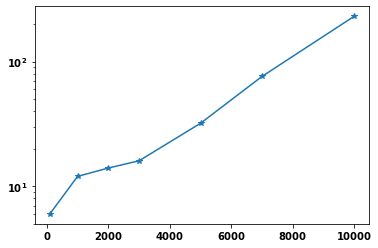

In [56]:
plt.plot([100, 1000, 2000, 3000, 5000, 7000, 10000], [len(x) for x in nans], '*-')
plt.yscale('log')

In [81]:
nans[5].size, nans[5]

(76,
 Int64Index([1006, 1027, 1040, 1043, 1047, 1064, 1068, 1073, 1079, 1082, 1087,
             1104, 1105, 1108, 1109, 1119, 1130, 1134, 1149, 1151, 1155, 1158,
             1164, 1173, 1184, 1186, 1188, 1196, 1198, 1199, 1205, 1209, 1215,
             1219, 1228, 1231, 1244, 1251, 1254, 1258, 1259, 1260, 1268, 1279,
             1284, 1292, 1311, 1318, 1321, 1322, 1327, 1335, 1359, 1361, 1376,
             1386, 1393, 1425, 1431, 1451, 1452, 1456, 1477, 1478, 1481, 1482,
             2003, 2004, 2013, 2018, 2019, 2020, 2022, 2024, 2030, 2036],
            dtype='int64'))

In [80]:
cc_df.loc[nans[6]].isna().sum(axis=1).values

array([2399, 2399, 2399, 1527, 2399, 2399, 2050, 2399, 1680, 2399, 2399,
       2399, 2399, 2399, 2399, 2399, 2399,  563, 2399, 2399, 1559,  848,
       2330, 2399, 2399, 2399, 2399,  308, 2399, 2399,  270, 2399, 2399,
        777,  494, 2399, 2399, 1770, 1887, 2399, 1666, 1534, 2399, 1994,
       1014, 2399, 2399, 2399,  186, 2399, 2399, 2399, 2399,  588, 2399,
       2399, 2399,  574, 2399, 2399, 2399, 2243, 2399, 2399, 2399, 2399,
       2399, 2399, 2399, 1995, 2399, 2399, 2399, 2399, 2399, 2399, 2399,
       1379,  730, 1353, 2399, 2399, 2399, 2399, 2399,  450, 2399,  122,
       2399, 2351, 2399,  538, 2399, 2399, 2399, 2399,  204,  687, 2399,
        412, 2054, 1823, 2399, 2399, 2218, 2399, 2399, 2399, 2399, 2399,
       2399, 1015, 1251, 1320, 2399, 2399,  716, 1134, 2399, 2399,  983,
       1819, 2399, 2399, 1331,  968, 2399, 2399, 2399,  814, 2399,  693,
       2399, 2399, 2399,  722, 2399, 2004, 2399, 2399, 2399, 2399, 2399,
       1581,  504, 2399, 2399, 2399,  529,  221, 23